# Adversarial Search: Playing Connect 4

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial state: Empty 6x7 board.
Actions: Drop a piece into one of the 7 columns.
Transition model: The transition model puts one piece of the current players color at the top of the column that they dropped it on.
Goal state: The terminal state is when the board has four pieces of the same color horizontally, vertically, or diagonally. The utility is +1 for a win for the player, -1 for a loss, and 0 for a draw.

How big is the state space? Give an estimate and explain it.

A rough estimate would be 3^(6x7) since every space in the grid has three possible states. However, this is much larger than the actual number of states as columns can only go from the bottom up. Let's focus on one column for now. Every column can have 0 to 6 pieces in it. Each filled slot on the grid would have two states, red and yellow. That means that one column has 2^0 + 2^1 + 2^2 + ... + 2^5 + 2^6 states or 2^(7)-1 = 127 states. 

Extending this out to 7 columns means that the board has an upper bound of 127^7 states. This isn't completely accurate either, as due to the rules of the game, each state can only have none or 1 more piece than the other color. Some states are also impossible to reach without ending the game earlier. For instance, a state where one of the columns has 6 adjacent red pieces is impossible as the game should have ended before that. This value is a decent upper bound though, so we'll stick with this number.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Each turn has 7 choices. Since there are 42 spots on the board, that would give us a tree with a size of 7^42. This is an overestimate of course due to the aforementioned early end states that the board can be in or that there are less choices once a column is full. This number is good enough though.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [126]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())
print(type(empty_board()))

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
<class 'numpy.ndarray'>


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

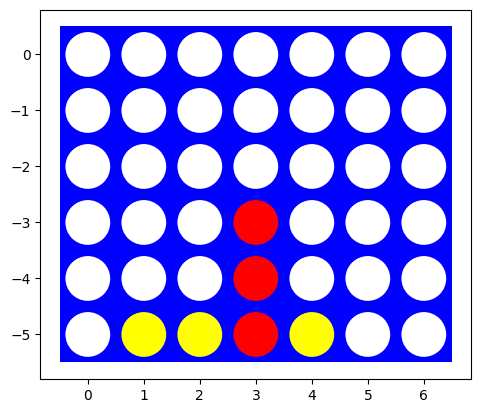

(6, 7)


In [127]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

test = [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0,-1,-1, 1,-1, 0, 0]]
visualize(test)
print(empty_board().shape)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [173]:
def isColumnFull(s: np.ndarray, colNum: int):
    if type(colNum) is not int: 
        print("isColumnFull() was given a non int for its colNum.")
        return None
    if colNum < 0 or colNum > s.shape[0]: 
        print("isColumnFull() was given out of bounds column number.")
        return None
    return s[0][colNum] != 0
    
def actions(s: np.ndarray):
    res = []
    for row in range(s.shape[1]):
        if not isColumnFull(s, row):
            res.append(row)
    return res

def result(s: np.ndarray, a: int, side: int):
    numRows = s.shape[0]
    numCols = s.shape[1]
    
    if a < 0 or a > numCols: return None
    if side != 1 and side != -1: return None

    res = s.copy()
    
    if isColumnFull(s, a):
        print(f"Column {a} full. Action failed.")
        return None

    for row in range(numRows):                       
        if row == numRows - 1 or (row < numRows and s[row+1][a] != 0):
            return fillSlot(s, a, row, side)
    
    print(f"ERROR: Results has reached end of function.")
    return None

def fillSlot(s: np.ndarray, row: int, col: int, side: int):
    res = s.copy()
    res[col][row] = side
    return res

def terminal(s: np.ndarray):
    rows = len(s)
    cols = len(s[0])
    
    # Check draw
    for col in range(cols):
        if not isColumnFull(s, col):
            break
        return 0
    
    # Check rows
    for row in s:
        for i in range(cols - 3):
            for j in range(rows):
                if row[i] != 0 and row[i] == row[i + 1] == row[i + 2] == row[i + 3]:
                    return row[i]
    
    # Check columns
    for i in range(rows - 3):
        for j in range(cols):
            if s[i][j] != 0 and s[i][j] == s[i + 1][j] == s[i + 2][j] == s[i + 3][j]:
                return s[i][j]
    
    # Check diagonals
    for i in range(rows - 3):
        for j in range(cols - 3):
            # Checks slopes
            if s[i][j] != 0 and s[i][j] == s[i + 1][j + 1] == s[i + 2][j + 2] == s[i + 3][j + 3]:
                return s[i][j]
            # Checks ramps
            elif s[i + 3][j] != 0 and s[i + 3][j] == s[i + 2][j + 1] == s[i + 1][j + 2] == s[i][j + 3]:
                return s[i + 3][j]
    
    # If no winner
    return None

True
[1, 2, 3, 4, 5, 6]
0


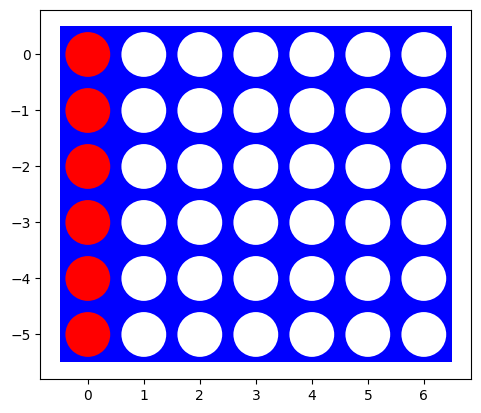

False
[0, 1, 2, 3, 4, 5, 6]
1


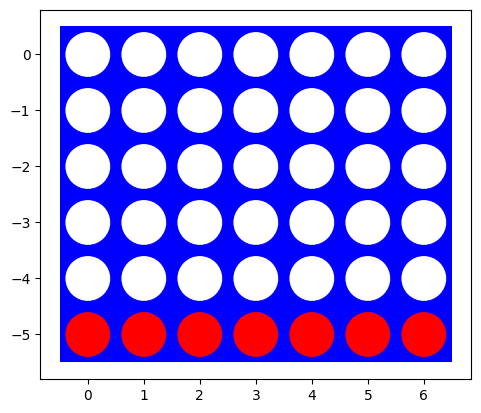

True
[1, 2, 3, 4, 5, 6]
0


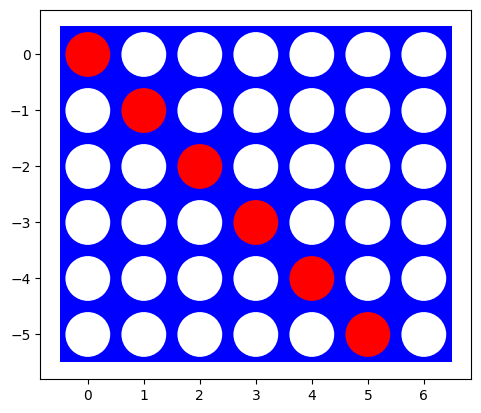

False
[0, 1, 2, 3, 4, 5]
-1


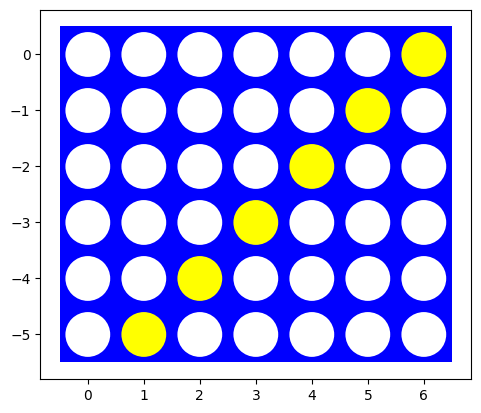

In [174]:
def test():
    empty = empty_board(shape=(6, 7))
    
    testCases = []
    
    # full column
    test = empty
    for i in range(6):
        test = result(test, 0, 1)
    testCases.append(test)
    
    # full row
    test = empty
    for i in range(7):
        test = result(test, i, 1)
    testCases.append(test)
    
    # full slope
    test = empty
    for i in range(6):
        test = fillSlot(test, i, i, 1)
    testCases.append(test)
    
    # full ramp
    test = empty
    test = empty
    for i in range(6):
        test = fillSlot(test, 6 - i, i, -1)
    testCases.append(test)
    
    for case in testCases:  
        print(isColumnFull(case, 0))
        print(actions(case))
        print(terminal(case))
        visualize(case)
        
test()

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [130]:
import random

def random_player(board: np.ndarray, player = 1):
    choices = actions(board)
    choice = random.randint(0, len(choices) - 1)
    #print(f"{choices}, {choice}")
    return result(board, choices[choice], player)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [131]:
def randomSim (numSims: int):
    numVics = 0
    numDraws = 0
    
    for i in range(numSims):
        simBoard = empty_board()
        while terminal(simBoard) is None:
            simBoard = random_player(simBoard, 1)
            if terminal(simBoard) is not None: break
            simBoard = random_player(simBoard, -1)
        outcome = terminal(simBoard)
        if outcome == 1: numVics += 1
        elif outcome == 0: numDraws += 1
        elif outcome is None: 
            print("ERROR: Simulation unintentionally ended early")
            visualize(simBoard)
        # if i < 3:
        #     visualize(simBoard)
    
    numOpVics = 1000-numVics-numDraws
    print(f"W/L ratio: {numVics}/{numOpVics} or {round(numVics/numOpVics, 2)}")
    print(f"Number of draws: {numDraws}")

sampleSize = 1000

for i in range(10):
    randomSim(sampleSize)

W/L ratio: 498/364 or 1.37
Number of draws: 138
W/L ratio: 502/347 or 1.45
Number of draws: 151
W/L ratio: 479/378 or 1.27
Number of draws: 143
W/L ratio: 480/385 or 1.25
Number of draws: 135
W/L ratio: 482/385 or 1.25
Number of draws: 133
W/L ratio: 500/364 or 1.37
Number of draws: 136
W/L ratio: 478/397 or 1.2
Number of draws: 125
W/L ratio: 493/367 or 1.34
Number of draws: 140
W/L ratio: 508/353 or 1.44
Number of draws: 139
W/L ratio: 491/384 or 1.28
Number of draws: 125


The first player wins more often than the second player by a significant margin, having an average win loss ratio of around 1.27. I expected it to be 50 50 odds, so when I saw this, I thought there was a bug in my code. However, thinking it over, having the first move is a considerable advantage. 

Say the red player goes first. Whenever red wins, they got 1 more move than yellow. Whenever yellow wins, they only get the same amount of moves as yellow. Therefore, in a random game, having more moves is equal to getting more chances to win.

This result, while unexpected (to me at least), does make sense.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [170]:
import math

class Minimax:
    def __init__(self, board: np.ndarray, moveValue = 1, debug = 0):
        self.numRows = board.shape[0]
        self.numCols = board.shape[1]
        self.board = board
        self.moveValue = moveValue
        
        self.debug = debug
        
    def makeMove(self, board: np.ndarray, player = 1):
        action = self.findMove()
        newBoard = result(board, action, self.moveValue)
        self.board = newBoard
        return newBoard
    
    def findMove(self, state: np.ndarray = None):
        if state is None: state = self.board
        value, action = self.maxValue(self.board)
        return action
    
    def maxValue(self, state: np.ndarray):
        utility = terminal(self.board)
        if utility is not None:
            return utility, None
        
        print("Max Value")
        visualize(state)
        
        value, move = -math.inf, -1
        for action in actions(self.board):
            v2, m2 = self.minValue(result(state, action, 1))
            if v2 > value: 
                value, move = v2, m2
        
        return value, move
            
    def minValue(self, state: np.ndarray):
        utility = terminal(self.board)
        if utility is not None:
            return utility
        
        print("Min Value")
        visualize(state)
        
        value, move = math.inf, -1
        for action in actions(self.board):
            v2, m2 = self.minValue(result(state, action, 1))
            if v2 < value: 
                value, move = v2, m2
        
        return value, move
            

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [167]:
def isBoardValid (board: np.ndarray):
    unique_values, counts = np.unique(board, return_counts=True)
    oneCount = counts[2]
    negCount = counts[0]
    if oneCount == negCount or oneCount == negCount + 1:
        return True
    return False

True
Max Value


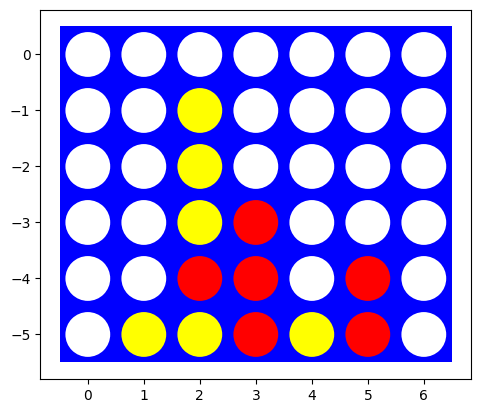

Min Value


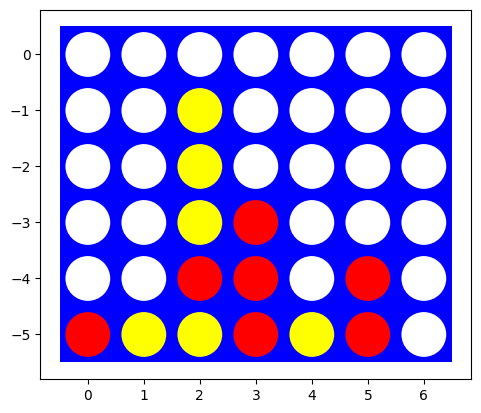

Min Value


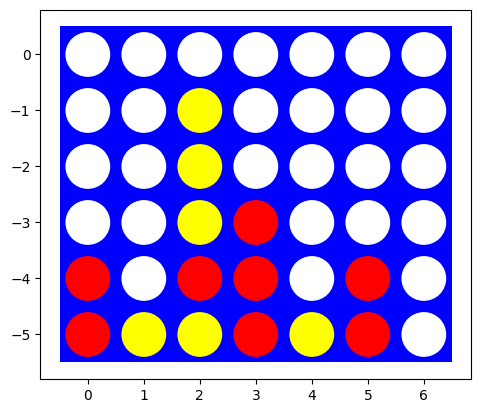

Min Value


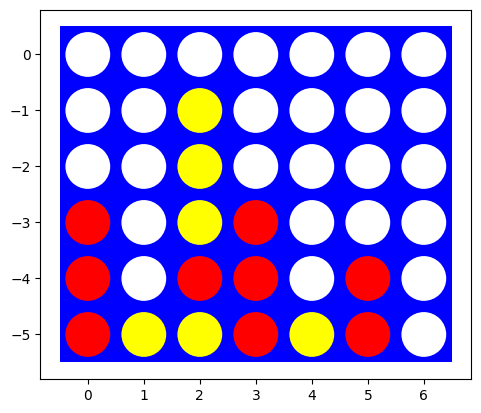

Min Value


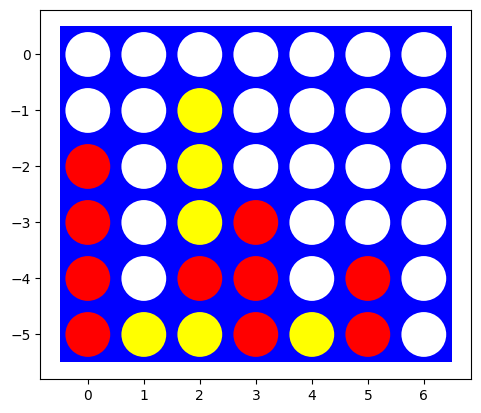

Min Value


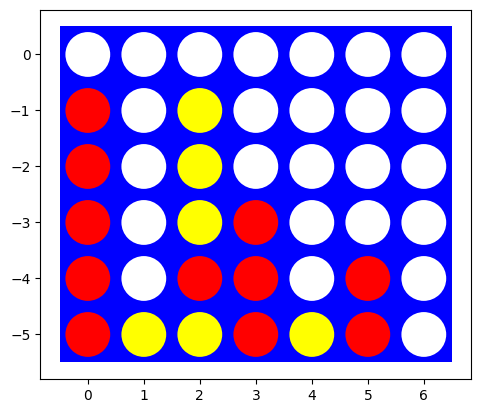

Min Value


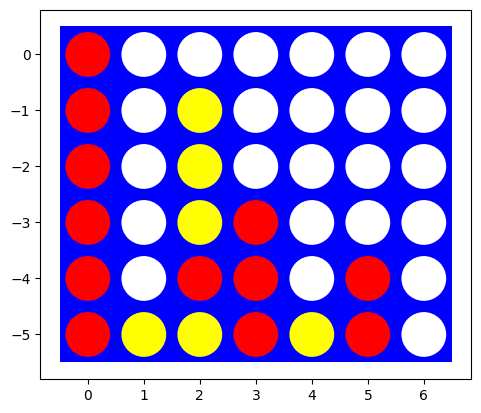

Column 0 full. Action failed.
Min Value


TypeError: object of type 'NoneType' has no len()

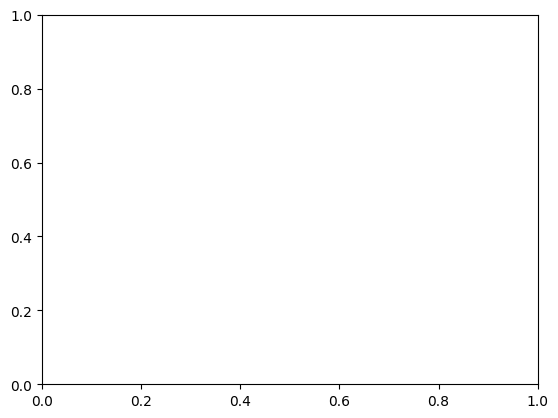

In [168]:
t1=  [[0, 0, 0, 0, 0, 0, 0],
      [0, 0,-1, 0, 0, 0, 0],
      [0, 0,-1, 0, 0, 0, 0],
      [0, 0,-1, 1, 0, 0, 0],
      [0, 0, 1, 1, 0, 1, 0],
      [0,-1,-1, 1,-1, 1, 0]]
t2 = [[0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0,-1, 0, 0],
      [0, 0, 0,-1,-1, 0, 0],
      [1, 0, 1, 1,-1, 1, 0]]

testCases = []
testCases.append(t1)
testCases.append(t2)
# testCases.append(t3)
# testCases.append(t4)
# testCases.append(t5)

for case in testCases:
    print(isBoardValid(case))
    search = Minimax(np.array(case))
    print(search.findMove())

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# Your code/ answer goes here.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.